# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**El dataset se puede descargar en el siguiente [link](https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX). Es un archivo .zip que contiene tres archivos. Para más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Este dataset cuenta con la siguiente [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt).**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_json('data/dataset_es_train.json', lines=True)

### Análisis Exploratorio y Limpieza de Datos

In [3]:
#Inicialmente se valida si por alguna razón se tienen registros duplicados
print("Total de registros duplicados:",len(data_train)-len(data_train.drop_duplicates()))

Total de registros duplicados: 0


In [4]:
#Revisamos si se tienen datos nulos
data_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [5]:
data_train.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics


In [6]:
#Nos quedamos únicamente con las columnas necesarias para resolver la pregunta que se tiene
data_train = data_train[['stars', 'review_body']]

In [7]:
data_train.shape

(200000, 2)

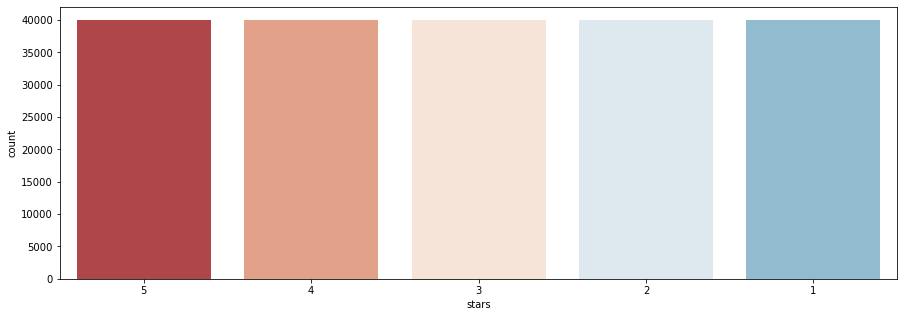

In [8]:
plt.figure(figsize = (15,5)) 
pal = sns.color_palette("RdBu")
sns.countplot(data=data_train, x="stars", order = data_train['stars'].value_counts().index, palette = pal)
plt.show()

Anteriormente se logró observar que se tienen **200000** registros, y en el gráfico anterior se observa que para cada etiqueta, en este caso el número de estrellas del comentario, se tienen la misma cantidad de muestras. Se tiene un dataset perfectamente balanceado.

Para continuar con nuestro análisis es necesario realizar una limpieza a los comentarios que se tienen, para ello utilizaremos el modelo para el idioma español de la librería **Spacy** y adicional utilizaremos una serie de funciones creadas mediante expresiones regulares que facilitarán este proceso de limpieza o normalización.

In [9]:
import spacy
import re

nlp = spacy.load('es_core_news_sm')

Se crearon varias funciones que facilitarán el trabajo de limpieza o normalización:
* **eliminar_caracteres**: Tiene como objetivo reemplazar todos los caracteres que el usuario le indique por un espacio. Por defecto la función reemplaza todos los caracteres especiales y númericos.

* **eliminar_espacios**: Tiene como objetivo eliminar espacios, cuando existan más de uno. Por ejemplo, 'Hola  Mundo  ', al pasar por la función quedaría 'Hola Mundo'.

* **eliminar_stopwords**: Tiene como objetivo eliminar las palabras que se pasen en el segundo parámtero de la función. Se utilizará para eliminar palabras que no aporten mucha información en el comentario, esto es lo que se conoce como stopwords.

* **eliminar_palabras_longitud**: Tiene como objetivo eliminar las palabras que tengan menos de ciertos caracteres, los cuales se definen con el parámetro **longitud**, que por defecto viene en **3**. Adicional se puede indicar una lista de palabras para no eliminar, mediante el parámetro **excluir_palabra**, el cual por defecto excluye la palabra **no**. El último parámetro que trae esta función es **activar_exluir**, que por defecto viene en True, con False podemos indicarle que no se desea excluir ninguna palabra.

* **lemmatizar**: Tiene como objetivo realizar la lematización de las palabras. Para ello nos apoyamos de la librería Spacy.

* **eliminar_acentos**: Tiene como objetivo eliminar los acentos que se indiquen. Con el parámetro **acentos_eliminar** se indica los acentos que se desean eliminar, por defecto se eliminan las tildes en las vocales y la diéresis en la letra **u**. Con el parámetro **acentos_reemplazo**, se indica como quedaría el carácter sin el acento. Hay que resaltar que está función solo los valores por defecto se trabaja únicamente para las letras en minúscula.

* **crear_ngrams**: Tiene como objetivo crear ngrams, por defecto el parámetro **ngrams** es igual, lo cual indica que el texto se va a separar por palabra. Si se desea separar por dos palabras se debe pasar **ngrams** como igual a 2, y así sucesivamente.

In [10]:
def eliminar_caracteres(text, caracteres = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡1234567890'):
    return re.sub('[%s]' % re.escape(caracteres), ' ', text)

def eliminar_espacios(text):
    return " ".join(re.split("\s+", text, flags=re.UNICODE)).strip()

def eliminar_stopwords(text, stopwords):
    edit_string_as_list = text.split()
    final_list = [word for word in edit_string_as_list if word not in stopwords]
    return ' '.join(final_list)

def eliminar_palabras_longitud(text, longitud = 3, excluir_palabra = ['no'], activar_exluir = True):
    edit_string_as_list = text.split()
    if activar_exluir:
        words = [word for word in edit_string_as_list if word in excluir_palabra or len(word) > longitud]
    else:
        words = [word for word in edit_string_as_list if len(word) > longitud]
    return ' '.join(words)

def lemmatizar(text):
    edit_string_as_list = nlp(text)
    final_list = [word.lemma_ for word in edit_string_as_list]
    return ' '.join(final_list)

def eliminar_acentos(text, acentos_eliminar = 'áéíóúü', acentos_reemplazo = 'aeiouu'):
    trans = str.maketrans(acentos_eliminar,acentos_reemplazo)
    return text.translate(trans)

def crear_ngrams(text, ngrams=1):
    tokens = text.split()
    list_tokens = [tokens[i:i+ngrams] for i in range(len(tokens)-ngrams+1)]
    for i in range(len(list_tokens)):
        list_tokens[i] = ' '.join(list_tokens[i])
    return '##'.join(list_tokens)

Cargamos el stopwords de Spacy manualmente, para poder quitar la palabra **no** de este listado, dado que se considera que puede agregar bastante información a la hora de trabajar con bigramas o trigramas.

In [11]:
STOP_WORDS = ['actualmente','acuerdo','adelante','ademas','además','adrede','afirmó','agregó','ahi','ahora','ahí','al','algo',
'alguna','algunas','alguno','algunos','algún','alli','allí','alrededor','ambos','ampleamos','antano','antaño','ante','anterior',
'antes','apenas','aproximadamente','aquel','aquella','aquellas','aquello','aquellos','aqui','aquél','aquélla','aquéllas',
'aquéllos','aquí','arriba','arriba','abajo','aseguró','asi','así','atras','aun','aunque','ayer','añadió','aún','bajo',
'bastante','bien','breve','buen','buena','buenas','bueno','buenos','cada','casi','cerca','cierta','ciertas','cierto','ciertos',
'cinco','claro','comentó','como','con','conmigo','conocer','conseguimos','conseguir','considera','consideró','consigo',
'consigue','consiguen','consigues','contigo','contra','cosas','creo','cual','cuales','cualquier','cuando','cuanta','cuantas',
'cuanto',
'cuantos','cuatro','cuenta','cuál','cuáles','cuándo','cuánta','cuántas','cuánto','cuántos','cómo','da','dado','dan','dar','de',
'debajo','debe','deben','debido','decir','dejó','del','delante','demasiado','demás','dentro','deprisa','desde','despacio',
'despues','después','detras','detrás','dia','dias','dice','dicen','dicho','dieron','diferente','diferentes','dijeron','dijo',
'dio','donde','dos','durante','día','días','dónde','ejemplo','el','ella','ellas','ello','ellos','embargo','empleais','emplean',
'emplear','empleas','empleo','en','encima','encuentra','enfrente','enseguida','entonces','entre','era','eramos','eran','eras',
'eres','es','esa','esas','ese','eso','esos','esta','estaba','estaban','estado','estados','estais','estamos','estan','estar',
'estará','estas','este','esto','estos','estoy','estuvo','está','están','ex','excepto','existe','existen','explicó','expresó',
'fin','final','fue','fuera','fueron','fui','fuimos','general','gran','grandes','gueno','ha','haber','habia','habla','hablan',
'habrá','había','habían','hace','haceis','hacemos','hacen','hacer','hacerlo','haces','hacia','haciendo','hago','han','hasta',
'hay','haya','he','hecho','hemos','hicieron','hizo','horas','hoy','hubo','igual','incluso','indicó','informo','informó',
'intenta','intentais','intentamos','intentan','intentar','intentas','intento','ir','junto','la','lado','largo','las','le',
'lejos','les','llegó','lleva','llevar','lo','los','luego','lugar','mal','manera','manifestó','mas','mayor','me','mediante',
'medio','mejor','mencionó','menos','menudo','mi','mia','mias','mientras','mio','mios','mis','misma','mismas','mismo','mismos',
'modo','momento','mucha','muchas','mucho','muchos','muy','más','mí','mía','mías','mío','míos','nada','nadie','ni','ninguna',
'ningunas','ninguno','ningunos','ningún','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','nueva',
'nuevas','nuevo','nuevos','nunca','ocho','os','otra','otras','otro','otros','pais','para','parece','parte','partir','pasada',
'pasado','paìs','peor','pero','pesar','poca','pocas','poco','pocos','podeis','podemos','poder','podria','podriais','podriamos',
'podrian','podrias','podrá','podrán','podría','podrían','poner','por','porque','posible','primer','primera','primero',
'primeros','principalmente','pronto','propia','propias','propio','propios','proximo','próximo','próximos','pudo','pueda',
'puede','pueden','puedo','pues','qeu','que','quedó','queremos','quien','quienes','quiere','quiza','quizas','quizá','quizás',
'quién','quiénes','qué','raras','realizado','realizar','realizó','repente','respecto','sabe','sabeis','sabemos','saben','saber',
'sabes','salvo','se','sea','sean','segun','segunda','segundo','según','seis','ser','sera','será','serán','sería','señaló','si',
'sido','siempre','siendo','siete','sigue','siguiente','sin','sino','sobre','sois','sola','solamente','solas','solo','solos',
'somos','son','soy','soyos','su','supuesto','sus','suya','suyas','suyo','sé','sí','sólo','tal','tambien','también','tampoco',
'tan','tanto','tarde','te','temprano','tendrá','tendrán','teneis','tenemos','tener','tenga','tengo','tenido','tenía','tercera',
'ti','tiempo','tiene','tienen','toda','todas','todavia','todavía','todo','todos','total','trabaja','trabajais','trabajamos',
'trabajan','trabajar','trabajas','trabajo','tras','trata','través','tres','tu','tus','tuvo','tuya','tuyas','tuyo','tuyos','tú',
'ultimo','un','una','unas','uno','unos','usa','usais','usamos','usan','usar','usas','uso','usted','ustedes','va','vais','valor',
'vamos','van','varias','varios','vaya','veces','ver','verdad','verdadera','verdadero','vez','vosotras','vosotros','voy',
'vuestra','vuestras','vuestro','vuestros','ya','yo','él','ésa','ésas','ése','ésos','ésta','éstas','éste','éstos','última',
'últimas','último','últimos','o']

In [12]:
%%time
data_train.review_body = data_train.review_body.str.lower() #Convertir a Minuscula
data_train.review_body = data_train.review_body.apply(lambda x: eliminar_caracteres(x))
data_train.review_body = data_train.review_body.apply(lambda x: eliminar_espacios(x))
data_train.review_body = data_train.review_body.apply(lambda x: eliminar_stopwords(x,STOP_WORDS))
data_train.review_body = data_train.review_body.apply(lambda x: lemmatizar(x))
data_train.review_body = data_train.review_body.apply(lambda x: eliminar_acentos(x))
data_train.review_body = data_train.review_body.apply(lambda x: eliminar_palabras_longitud(x))

Wall time: 15min 37s


In [13]:
#Se crean varios dataframes con los comentarios para cada categoría de estrellas
stars1 = data_train[data_train.stars == 1]
stars2 = data_train[data_train.stars == 2]
stars3 = data_train[data_train.stars == 3]
stars4 = data_train[data_train.stars == 4]
stars5 = data_train[data_train.stars == 5]

Se hace necesario crear la función **words_frequency**, la cual tiene como objetivo devolvernos un dataframe con las palabras que aparezcan en todo el texto junto con su frecuencia, ordenado de las más frecuentes a las menos frecuentes.

Este análisis se realizará para unigramas, bigramas y trigramas.

In [14]:
def words_frequency(text, ngrams=1):
    ngrams = text.apply(lambda x: crear_ngrams(x, ngrams=ngrams))
    stars_docs = '##'.join(ngrams)
    stars_freq = Counter(stars_docs.split("##"))
    df_stars = pd.DataFrame(list(stars_freq.items()), columns = ["Word","Frequency"])
    df_stars = df_stars[df_stars.Word != '']
    df_stars.sort_values('Frequency',ascending=False, inplace = True)
    return df_stars

### Unigramas

In [15]:
df_stars1 = words_frequency(stars1.review_body)
df_stars2 = words_frequency(stars2.review_body)
df_stars3 = words_frequency(stars3.review_body)
df_stars4 = words_frequency(stars4.review_body)
df_stars5 = words_frequency(stars5.review_body)

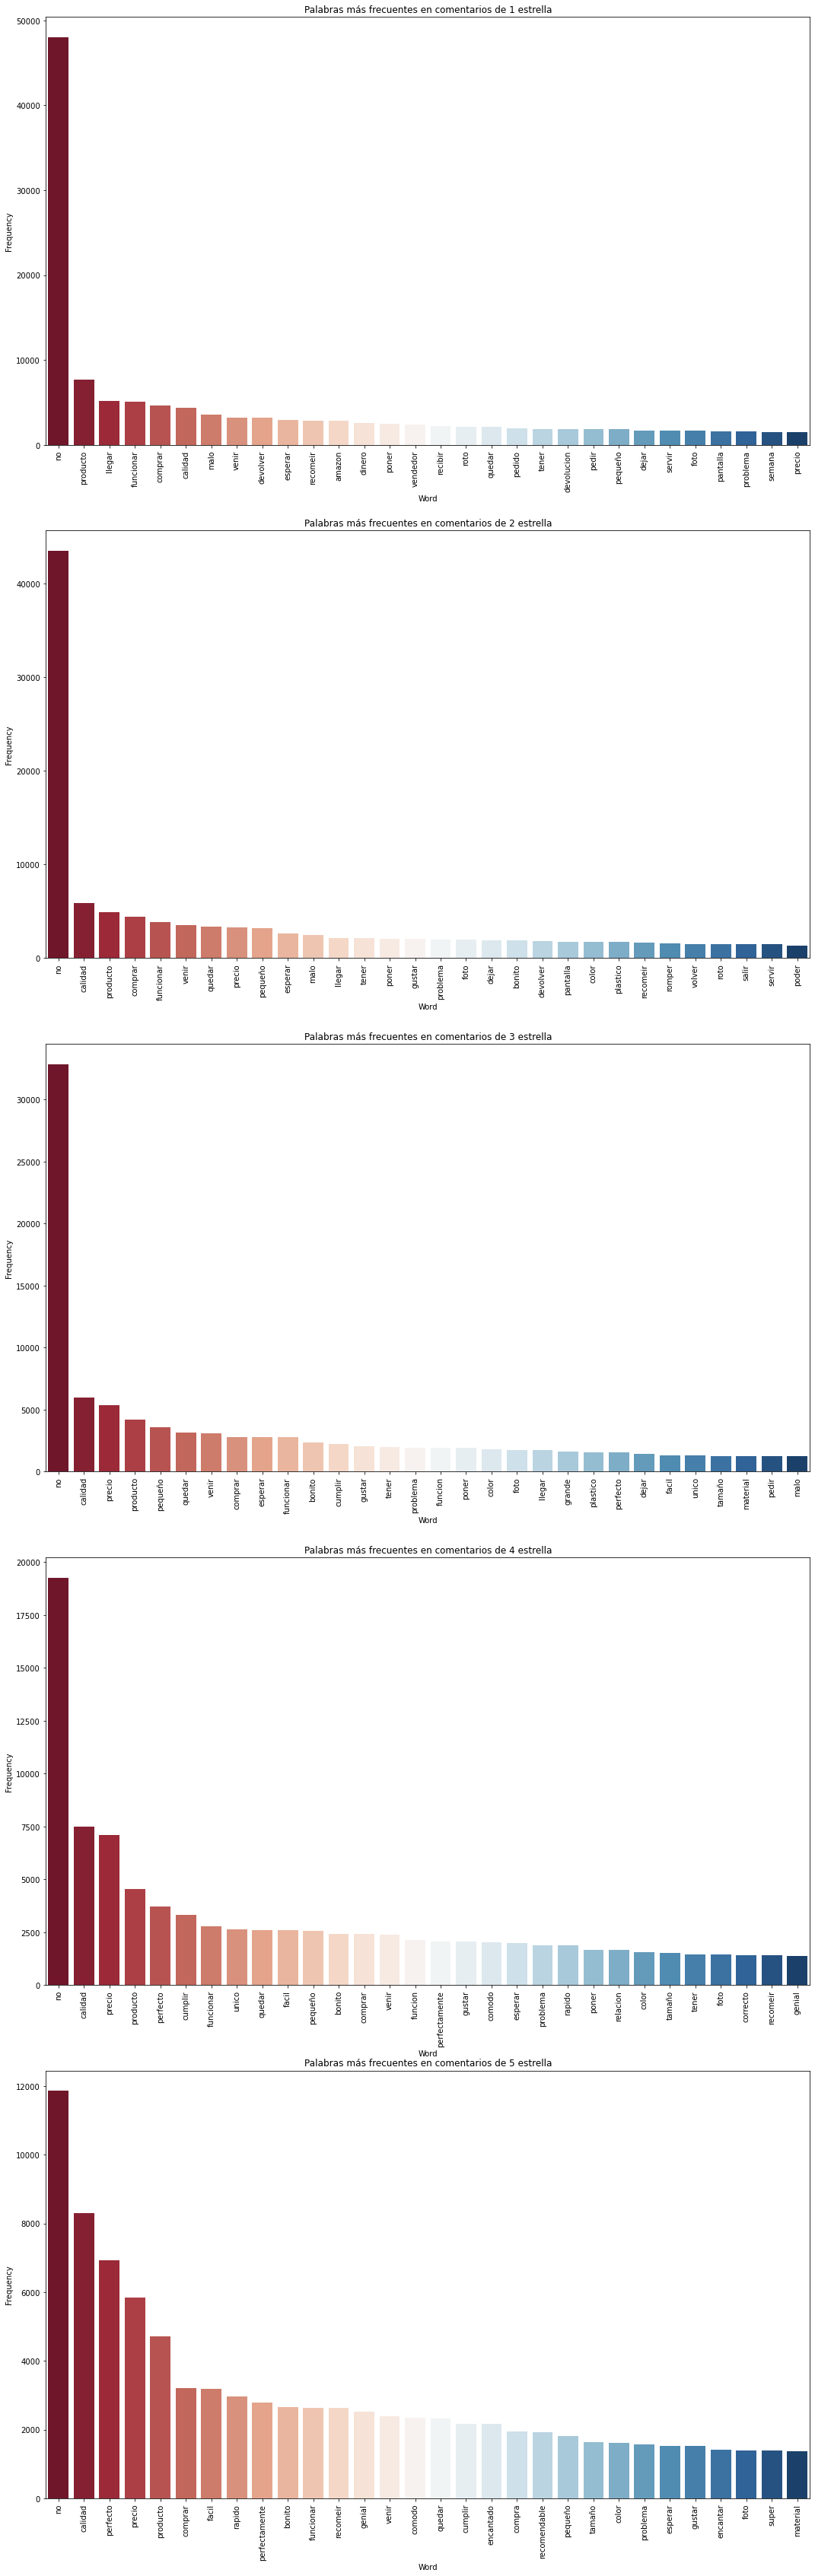

In [16]:
fig, axarr = plt.subplots(5, figsize=(18,60))

sns.barplot(x  = df_stars1.iloc[:30].Word, y = df_stars1.iloc[:30].Frequency, ax=axarr[0], palette="RdBu")
sns.barplot(x  = df_stars2.iloc[:30].Word, y = df_stars2.iloc[:30].Frequency, ax=axarr[1], palette="RdBu")
sns.barplot(x  = df_stars3.iloc[:30].Word, y = df_stars3.iloc[:30].Frequency, ax=axarr[2], palette="RdBu")
sns.barplot(x  = df_stars4.iloc[:30].Word, y = df_stars4.iloc[:30].Frequency, ax=axarr[3], palette="RdBu")
sns.barplot(x  = df_stars5.iloc[:30].Word, y = df_stars5.iloc[:30].Frequency, ax=axarr[4], palette="RdBu")

axarr[0].set_xticklabels(df_stars1.iloc[:30].Word, rotation='vertical')
axarr[1].set_xticklabels(df_stars2.iloc[:30].Word, rotation='vertical')
axarr[2].set_xticklabels(df_stars3.iloc[:30].Word, rotation='vertical')
axarr[3].set_xticklabels(df_stars4.iloc[:30].Word, rotation='vertical')
axarr[4].set_xticklabels(df_stars5.iloc[:30].Word, rotation='vertical')

axarr[0].title.set_text('Palabras más frecuentes en comentarios de 1 estrella')
axarr[1].title.set_text('Palabras más frecuentes en comentarios de 2 estrella')
axarr[2].title.set_text('Palabras más frecuentes en comentarios de 3 estrella')
axarr[3].title.set_text('Palabras más frecuentes en comentarios de 4 estrella')
axarr[4].title.set_text('Palabras más frecuentes en comentarios de 5 estrella')

fig.show()

En el anterior gráfico se visualiza las 30 palabras más frecuentes, para cada categoría de estrellas en los comentarios. Con ello se logra ver que algunas palabras son muy frecuentes en todas las categorías, lo cual realmente no apotaría información, incluso puede que generan confusiones al modelo al momento de intentar separar las clases. Por ello se crea otra lista de stopwords.

In [17]:
#Este Stopwords solo se implementará para trabajar con un solo gram
STOP_WORDS_1GRAM = ['no','producto','llegar','funcionar','comprar','calidad','venir','recomeir','quedar','problema','color',
                    'precio']

### Bigramas

In [18]:
df_stars1_2gram = words_frequency(stars1.review_body, ngrams=2)
df_stars2_2gram = words_frequency(stars2.review_body, ngrams=2)
df_stars3_2gram = words_frequency(stars3.review_body, ngrams=2)
df_stars4_2gram = words_frequency(stars4.review_body, ngrams=2)
df_stars5_2gram = words_frequency(stars5.review_body, ngrams=2)

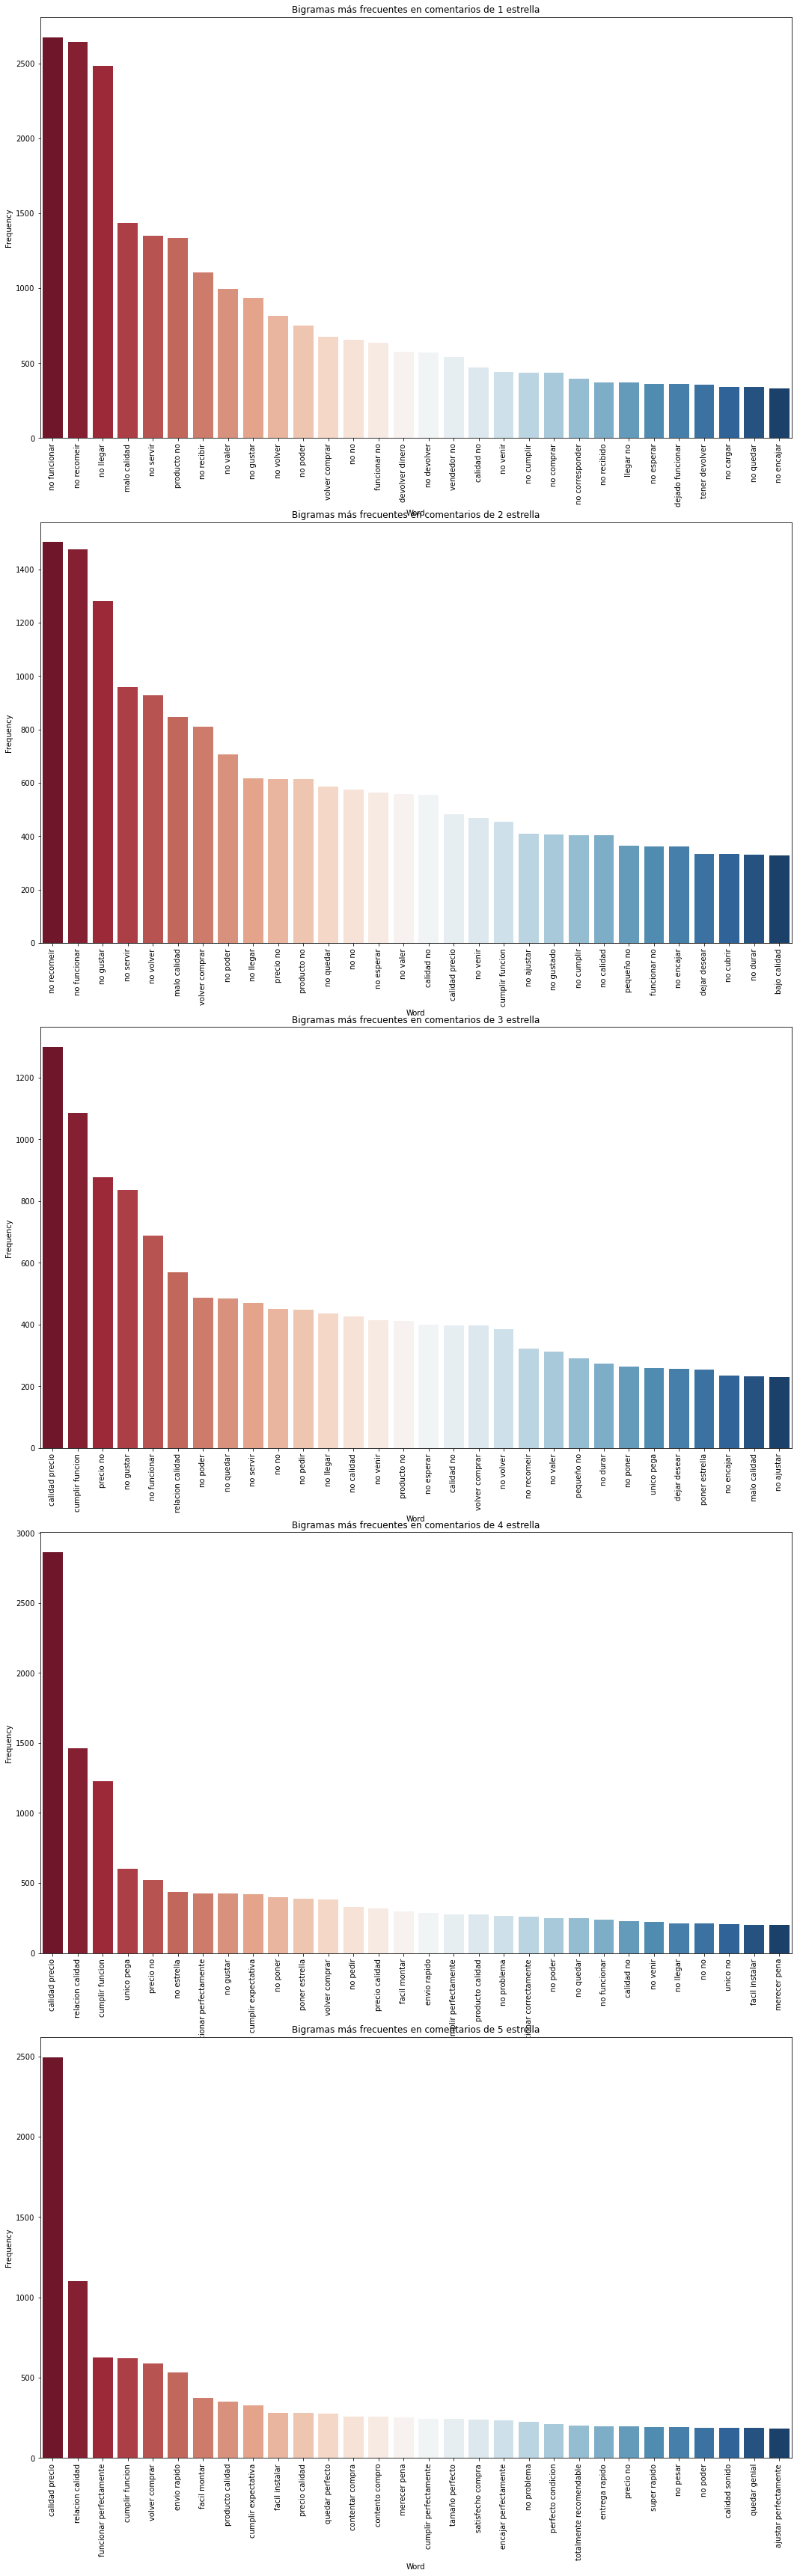

In [19]:
fig, axarr = plt.subplots(5, figsize=(18,60))

sns.barplot(x  = df_stars1_2gram.iloc[:30].Word, y = df_stars1_2gram.iloc[:30].Frequency, ax=axarr[0], palette="RdBu")
sns.barplot(x  = df_stars2_2gram.iloc[:30].Word, y = df_stars2_2gram.iloc[:30].Frequency, ax=axarr[1], palette="RdBu")
sns.barplot(x  = df_stars3_2gram.iloc[:30].Word, y = df_stars3_2gram.iloc[:30].Frequency, ax=axarr[2], palette="RdBu")
sns.barplot(x  = df_stars4_2gram.iloc[:30].Word, y = df_stars4_2gram.iloc[:30].Frequency, ax=axarr[3], palette="RdBu")
sns.barplot(x  = df_stars5_2gram.iloc[:30].Word, y = df_stars5_2gram.iloc[:30].Frequency, ax=axarr[4], palette="RdBu")

axarr[0].set_xticklabels(df_stars1_2gram.iloc[:30].Word, rotation='vertical')
axarr[1].set_xticklabels(df_stars2_2gram.iloc[:30].Word, rotation='vertical')
axarr[2].set_xticklabels(df_stars3_2gram.iloc[:30].Word, rotation='vertical')
axarr[3].set_xticklabels(df_stars4_2gram.iloc[:30].Word, rotation='vertical')
axarr[4].set_xticklabels(df_stars5_2gram.iloc[:30].Word, rotation='vertical')

axarr[0].title.set_text('Bigramas más frecuentes en comentarios de 1 estrella')
axarr[1].title.set_text('Bigramas más frecuentes en comentarios de 2 estrella')
axarr[2].title.set_text('Bigramas más frecuentes en comentarios de 3 estrella')
axarr[3].title.set_text('Bigramas más frecuentes en comentarios de 4 estrella')
axarr[4].title.set_text('Bigramas más frecuentes en comentarios de 5 estrella')

fig.show()

### Trigramas

In [20]:
df_stars1_3gram = words_frequency(stars1.review_body, ngrams=3)
df_stars2_3gram = words_frequency(stars2.review_body, ngrams=3)
df_stars3_3gram = words_frequency(stars3.review_body, ngrams=3)
df_stars4_3gram = words_frequency(stars4.review_body, ngrams=3)
df_stars5_3gram = words_frequency(stars5.review_body, ngrams=3)

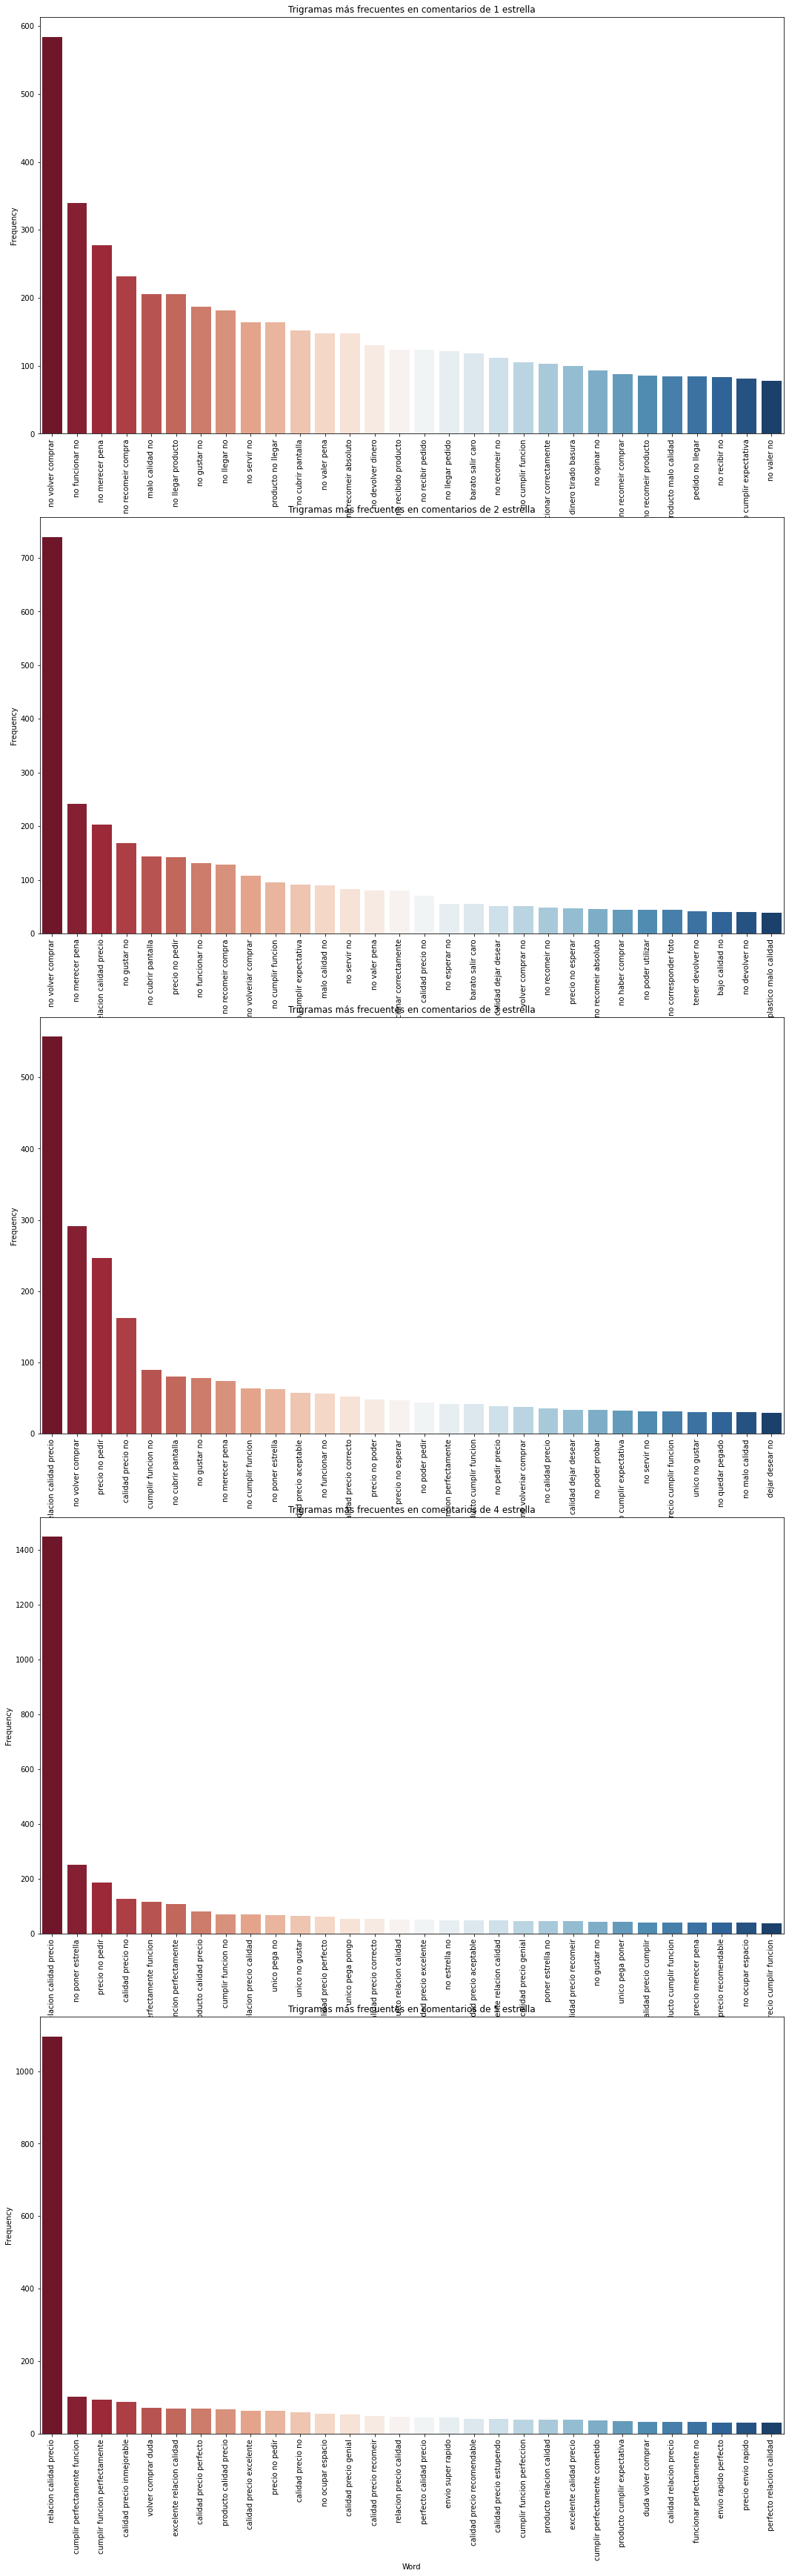

In [21]:
fig, axarr = plt.subplots(5, figsize=(18,60))

sns.barplot(x  = df_stars1_3gram.iloc[:30].Word, y = df_stars1_3gram.iloc[:30].Frequency, ax=axarr[0], palette="RdBu")
sns.barplot(x  = df_stars2_3gram.iloc[:30].Word, y = df_stars2_3gram.iloc[:30].Frequency, ax=axarr[1], palette="RdBu")
sns.barplot(x  = df_stars3_3gram.iloc[:30].Word, y = df_stars3_3gram.iloc[:30].Frequency, ax=axarr[2], palette="RdBu")
sns.barplot(x  = df_stars4_3gram.iloc[:30].Word, y = df_stars4_3gram.iloc[:30].Frequency, ax=axarr[3], palette="RdBu")
sns.barplot(x  = df_stars5_3gram.iloc[:30].Word, y = df_stars5_3gram.iloc[:30].Frequency, ax=axarr[4], palette="RdBu")

axarr[0].set_xticklabels(df_stars1_3gram.iloc[:30].Word, rotation='vertical')
axarr[1].set_xticklabels(df_stars2_3gram.iloc[:30].Word, rotation='vertical')
axarr[2].set_xticklabels(df_stars3_3gram.iloc[:30].Word, rotation='vertical')
axarr[3].set_xticklabels(df_stars4_3gram.iloc[:30].Word, rotation='vertical')
axarr[4].set_xticklabels(df_stars5_3gram.iloc[:30].Word, rotation='vertical')

axarr[0].title.set_text('Trigramas más frecuentes en comentarios de 1 estrella')
axarr[1].title.set_text('Trigramas más frecuentes en comentarios de 2 estrella')
axarr[2].title.set_text('Trigramas más frecuentes en comentarios de 3 estrella')
axarr[3].title.set_text('Trigramas más frecuentes en comentarios de 4 estrella')
axarr[4].title.set_text('Trigramas más frecuentes en comentarios de 5 estrella')

fig.show()

Del análisis realizado para bigramas y trigramas se puede concluir que son un poco más comunicativos, en cuanto a la relación con el comentario a diferencia de los unigramas. Pero al ser más palabras las frecuencias disminuyen considerablemente, para lo cual se haría poco generalizable un modelo utilizando bigramas o trigramas, por lo cual la modelación se decide realizar únicamente con unigramas.


Para facilitar la limpieza o normalización de los comentarios, se crea la función **normalize**, la cual tiene como objetivo aplicar las funciones anteriormente creadas en un orden específico que permita una mejor limpieza.

In [22]:
def normalize(text, STOP_WORDS, activar_exluir = True):
    data = str.lower(text) #Convertir a Minuscula
    data = eliminar_caracteres(data)
    data = eliminar_espacios(data)
    data = eliminar_stopwords(data,STOP_WORDS)
    data = lemmatizar(data)
    data = eliminar_acentos(data)
    data = eliminar_palabras_longitud(data, activar_exluir = activar_exluir)
    return data

## Modelación

En esta ocasión nos entregaron 3 conjuntos de datos, el de **train** que utilizaremos para entrenar, el de **test** para optimizar los hiperparámetros de los modelos que utilicen y el de **dev** para realizar una pequeña simulación del modelo final en un ambiente productivo.

Como anteriormente se logró observar, y es que nuestros datos en train están perfectamente balanceados, se utilizará el **accuracy** como métrica para evaluar y comparar los modelos que se realicen.

In [23]:
data_train = pd.read_json('data/dataset_es_train.json', lines=True)
data_test = pd.read_json('data/dataset_es_test.json', lines=True)

Se aplica la función **normalize** creada, para los conjuntos de datos de **train** y **test**.

In [24]:
%%time
data_train['review_normalize'] = data_train.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))
data_test['review_normalize'] = data_test.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))

Wall time: 16min 40s


In [25]:
data_train.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_normalize
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,pantalla recibido respuesta fabricante
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,horrible tener ingles informatico hora capaz i...


Se crean los datasets necesarios para entrenar y evaluar los modelos a utilizar.

In [26]:
X_train = data_train['review_normalize']
y_train = data_train['stars']

X_test = data_test['review_normalize']
y_test = data_test['stars']

Para poder ingresar los comentarios en los modelos que se utilizarán, es necesario vectorizar nuestro conjunto de datos. Para ello existen varias técnicas, de las cuales para la solución de este problema utilizaremos **Bag of Words**. La cual crea una matriz con las **n** palabras más frecuentes, y en cada registro, coloca **1** o **0** indicando si el comentario contiene la palabra o no. El valor de **n** se puede especificar en un parámetro.

La construcción de los modelos se realizará con ayuda de la librería **Pipeline**, la cual nos permite crear flujos de trabajo, para aplicar ciertas funciones de manera secuencial, y adicional permite mezclarlo con **GridSearch**. Esta mezcla nos permitirá encontrar el mejor modelo incluyendo la variación del parámetro de la cantidad de palabras en la técnica de vectorización a aplicar.

### Modelo Benchmark - Árbol de Decisión

Como modelo **benchmark**, se aplicará un **árbol de decisión** con una profundidad máxima de 20, y se aplicará la vectorización con un máximo de **1000** palabras.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [28]:
steps_tree = [('vectorizer', CountVectorizer(max_features=1000)), ('Tree', DecisionTreeClassifier(max_depth=20,
                                                                                                   random_state = 42))] 
pipeline_tree = Pipeline(steps_tree)

In [29]:
%%time
pipeline_tree.fit(X_train, y_train)

Wall time: 6.64 s


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('Tree',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [30]:
y_train_pred_tree = pipeline_tree.predict(X_train)
y_test_pred_tree = pipeline_tree.predict(X_test)
accuracy_train_tree = accuracy_score(y_train, y_train_pred_tree)
accuracy_test_tree = accuracy_score(y_test, y_test_pred_tree)
print(f'Accuracy en Train: {round(accuracy_train_tree*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_tree*100,2)}')

Accuracy en Train: 35.62
Accuracy en Test: 33.94


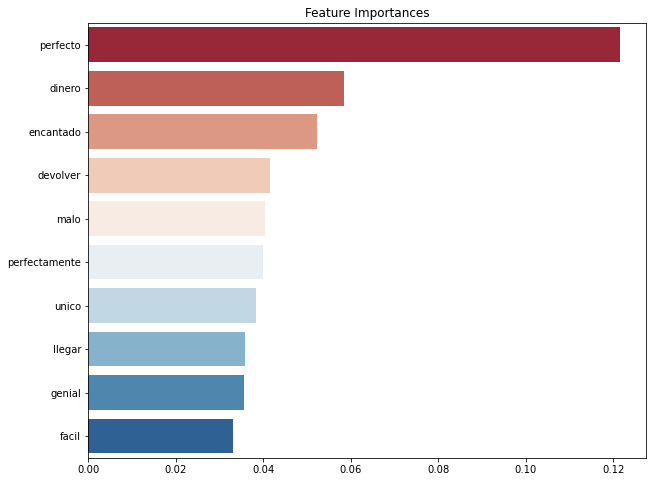

In [31]:
importances = pipeline_tree['Tree'].feature_importances_
indices = np.argsort(importances)[::-1]
columns = np.array(pipeline_tree['vectorizer'].get_feature_names())

plt.figure(figsize=(10, 8))
sns.barplot(importances[indices][:10], columns[indices][:10], palette="RdBu")
plt.title('Feature Importances')
plt.show()

En el gráfico anterior se encuentran las palabras más importantes para el modelo a la hora de predecir a que clase pertenece. Se observa una gran importancia de un poco más del doble respecto a la que sigue, de la palabra **perfecto**. También podemos notar palabras que pueden indicar fácilmente si el comentario es malo o no, por lo que se puede esperar que el modelo sea un poco mejor prediciendo los comentarios de **5 estrellas** y **1 estrella**.

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_tree))

              precision    recall  f1-score   support

           1       0.54      0.34      0.42      1000
           2       0.24      0.72      0.36      1000
           3       0.34      0.04      0.07      1000
           4       0.41      0.20      0.27      1000
           5       0.51      0.39      0.44      1000

    accuracy                           0.34      5000
   macro avg       0.41      0.34      0.31      5000
weighted avg       0.41      0.34      0.31      5000



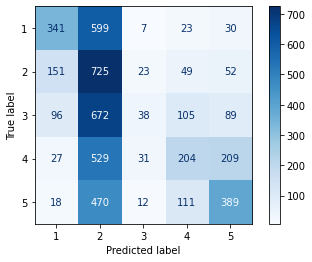

In [33]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_tree, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

En la anterior salida, la cual nos entrega el **classification_report** se puede ver que se tiene una alta **precision** en los comentarios de **5 estrellas** y **1 estrella** como se podía intituir. Esto también nos ayuda a suponer que el modelo puede mejorar bastante si el problema se convierte en binario, en si el comentario es positivo o no.

### Support Vector Machine - Kernel Lineal

In [34]:
from sklearn.svm import LinearSVC

In [35]:
steps_svm = [('vectorizer', CountVectorizer()), ('SVM', LinearSVC(random_state = 42))] 
pipeline_svm = Pipeline(steps_svm) 

In [36]:
param_grid_svm = {'vectorizer__max_features': [500, 1000, 1500, 2000],
                  'SVM__C': [0.1, 1, 10],
                  'SVM__penalty': ['l1', 'l2']}

In [37]:
%%time
grid_svm = GridSearchCV(pipeline_svm, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

Wall time: 1h 3min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('SVM', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'SVM__C': [0.1, 1, 10], 'SVM__penalty': ['l1', 'l2'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [38]:
print("Mejores Hiperparámetros:", grid_svm.best_params_)
print("Mejor Accuracy Promedio Obtenido en Test:", round(grid_svm.best_score_*100,2))

Mejores Hiperparámetros: {'SVM__C': 10, 'SVM__penalty': 'l2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido en Test: 44.46


In [39]:
y_train_pred_svm = grid_svm.predict(X_train)
y_test_pred_svm = grid_svm.predict(X_test)
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
print(f'Accuracy en Train: {round(accuracy_train_svm*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_svm*100,2)}')

Accuracy en Train: 46.89
Accuracy en Test: 44.1


In [40]:
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           1       0.53      0.66      0.59      1000
           2       0.38      0.30      0.34      1000
           3       0.34      0.29      0.32      1000
           4       0.38      0.31      0.34      1000
           5       0.50      0.64      0.56      1000

    accuracy                           0.44      5000
   macro avg       0.43      0.44      0.43      5000
weighted avg       0.43      0.44      0.43      5000



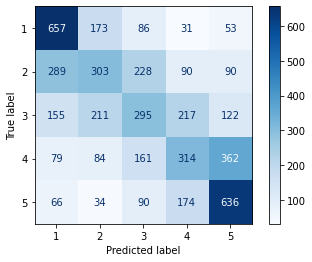

In [41]:
plot_confusion_matrix(grid_svm, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
steps_rf = [('vectorizer', CountVectorizer()), ('RandomForest', RandomForestClassifier(n_estimators = 100, random_state=42))] 
pipeline_rf = Pipeline(steps_rf) 

In [44]:
param_grid_rf = {'vectorizer__max_features': [500, 1000, 1500, 2000],
                 'RandomForest__max_depth': np.arange(10,30,5),
                 'RandomForest__max_features': ['sqrt', 'log2', 'auto']}

In [45]:
%%time
rf_grid = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

Wall time: 39min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RandomForest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': array([10, 15, 20, 25]),
                         'RandomForest__max_features': ['sqrt', 'log2', 'auto'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [46]:
print("Mejores Hiperparámetros:", rf_grid.best_params_)
print("Mejor Accuracy Promedio Obtenido en Test:", round(rf_grid.best_score_*100,2))

Mejores Hiperparámetros: {'RandomForest__max_depth': 25, 'RandomForest__max_features': 'log2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido en Test: 42.12


In [47]:
y_train_pred_rf = rf_grid.predict(X_train)
y_test_pred_rf = rf_grid.predict(X_test)
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy en Train: {round(accuracy_train_rf*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_rf*100,2)}')

Accuracy en Train: 50.13
Accuracy en Test: 41.84


In [48]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           1       0.52      0.61      0.56      1000
           2       0.37      0.25      0.30      1000
           3       0.29      0.35      0.32      1000
           4       0.38      0.30      0.33      1000
           5       0.50      0.58      0.54      1000

    accuracy                           0.42      5000
   macro avg       0.41      0.42      0.41      5000
weighted avg       0.41      0.42      0.41      5000



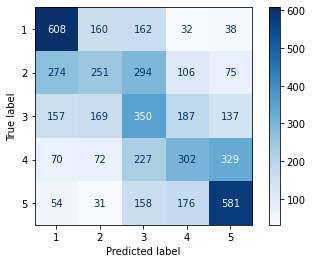

In [49]:
plot_confusion_matrix(rf_grid, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

Comparando los resultados de los modelos anteriormente aplicados en el conjunto de datos en **test** tenemos:

* Modelo benchmark - árbol de decisión: **33.94%**
* Support vector machine - kernel lineal: **44.1%**
* Random forest: **41.84%**

Por lo tanto, tomando como referencia el que obtuvo mejor resultado, nos podemos quedar con el modelo de **Support vector machine con kernel lineal**.

Uno de los temas, que nos colocan como interrogante era si el modelo puede mejorar o no si lo convertimos en binario. Como se comentó en las conclusiones obtenidas en el modelo benchmark, se puede decir que el modelo debería mejorar bastante y valdrá la pena convertirlo en binario.

## Convertir Problema en Binario

Para convertir nuestro problema en binario, se creará una nueva variable que indique si el comentario es positivo o no. Para crear dicha variable tomaremos los comentarios con 4 y 5 estrellas como comentarios positivos, y los comentarios con 1 y 2 estrellas como comentarios negativos. Los comentarios con 3 estrellas quedarán fuera del análisis dado que se consideran como comentarios neutrales.

In [50]:
data_train_binario = data_train[data_train.stars != 3]
data_test_binario = data_test[data_test.stars != 3]

In [51]:
data_train_binario['Ind_Positivo'] = np.where(data_train_binario.stars >= 4, 1, 0)
data_test_binario['Ind_Positivo'] = np.where(data_test_binario.stars >= 4, 1, 0)

In [52]:
X_train_binario = data_train_binario['review_normalize']
y_train_binario = data_train_binario['Ind_Positivo']

X_test_binario = data_test_binario['review_normalize']
y_test_binario = data_test_binario['Ind_Positivo']

Ahora con nuestro dataset transformado, para que el problema sea binario, ejecutamos nuevamente los modelos realizados para el problema multiclase. Esto dado que nuestras variable objetivo cambió y puede que el mejor modelo sea un algotimo distinto, o quizás el mismo pero con hiperparámetros diferentes.

### Modelo Benchmark

In [53]:
steps_tree_binario = [('vectorizer', CountVectorizer(max_features=1000)), ('Tree', DecisionTreeClassifier(max_depth=20,
                                                                                                          random_state = 42))] 
pipeline_tree_binario = Pipeline(steps_tree_binario)

In [54]:
%%time
pipeline_tree_binario.fit(X_train_binario, y_train_binario)

Wall time: 9.85 s


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('Tree',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [55]:
y_train_pred_tree_binario = pipeline_tree_binario.predict(X_train_binario)
y_test_pred_tree_binario = pipeline_tree_binario.predict(X_test_binario)
accuracy_train_tree_binario = accuracy_score(y_train_binario, y_train_pred_tree_binario)
accuracy_test_tree_binario = accuracy_score(y_test_binario, y_test_pred_tree_binario)
print(f'Accuracy en Train: {round(accuracy_train_tree_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_tree_binario*100,2)}')

Accuracy en Train: 71.75
Accuracy en Test: 71.12


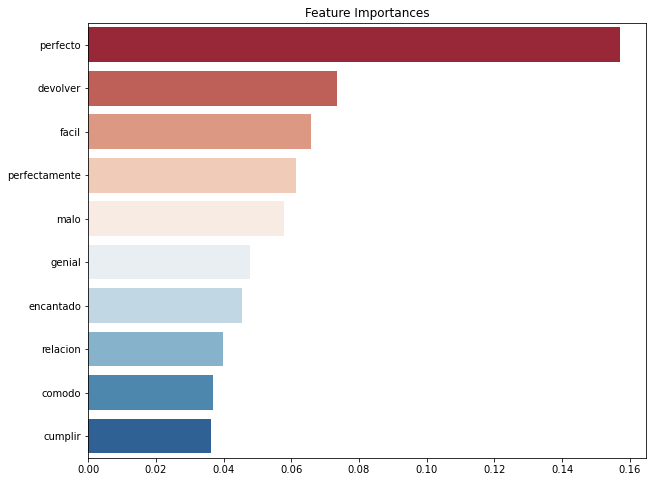

In [56]:
importances_binario = pipeline_tree_binario['Tree'].feature_importances_
indices_binario = np.argsort(importances_binario)[::-1]
columns_binario = np.array(pipeline_tree_binario['vectorizer'].get_feature_names())

plt.figure(figsize=(10, 8))
sns.barplot(importances_binario[indices_binario][:10], columns_binario[indices_binario][:10], palette="RdBu")
plt.title('Feature Importances')
plt.show()

In [57]:
print(classification_report(y_test_binario, y_test_pred_tree_binario))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76      2000
           1       0.86      0.51      0.64      2000

    accuracy                           0.71      4000
   macro avg       0.75      0.71      0.70      4000
weighted avg       0.75      0.71      0.70      4000



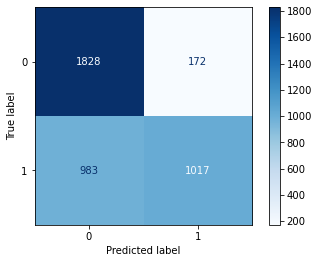

In [58]:
plot_confusion_matrix(pipeline_tree_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

### Support Vector Machine - Kernel Lineal

In [59]:
steps_svm_binario = [('vectorizer', CountVectorizer()), ('SVM', LinearSVC(random_state = 42))] 
pipeline_svm_binario = Pipeline(steps_svm_binario) 

In [60]:
%%time
grid_svm_binario = GridSearchCV(pipeline_svm_binario, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_binario.fit(X_train_binario, y_train_binario)

Wall time: 11min 57s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('SVM', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'SVM__C': [0.1, 1, 10], 'SVM__penalty': ['l1', 'l2'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [61]:
print("Mejores Hiperparámetros:", grid_svm_binario.best_params_)
print("Mejor Accuracy Promedio Obtenido en Test:", round(grid_svm_binario.best_score_*100,2))

Mejores Hiperparámetros: {'SVM__C': 0.1, 'SVM__penalty': 'l2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido en Test: 82.0


In [62]:
y_train_pred_svm_binario = grid_svm_binario.predict(X_train_binario)
y_test_pred_svm_binario = grid_svm_binario.predict(X_test_binario)
accuracy_train_svm_binario = accuracy_score(y_train_binario, y_train_pred_svm_binario)
accuracy_test_svm_binario = accuracy_score(y_test_binario, y_test_pred_svm_binario)
print(f'Accuracy en Train: {round(accuracy_train_svm_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_svm_binario*100,2)}')

Accuracy en Train: 83.69
Accuracy en Test: 82.6


In [63]:
print(classification_report(y_test_binario, y_test_pred_svm_binario))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2000
           1       0.82      0.83      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



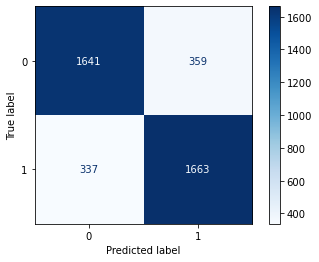

In [64]:
plot_confusion_matrix(grid_svm_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

### Random Forest

In [65]:
steps_rf_binario = [('vectorizer', CountVectorizer()), ('RandomForest', RandomForestClassifier(n_estimators = 100, 
                                                                                               random_state=42))] 
pipeline_rf_binario = Pipeline(steps_rf_binario)

In [66]:
%%time
rf_grid_binario = GridSearchCV(pipeline_rf_binario, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_binario.fit(X_train_binario, y_train_binario)

Wall time: 25min 3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RandomForest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': array([10, 15, 20, 25]),
                         'RandomForest__max_features': ['sqrt', 'log2', 'auto'],
                         'vectorizer__max_features': [500, 1000, 1500, 2000]},
             scoring='accuracy')

In [67]:
print("Mejores Hiperparámetros:", rf_grid_binario.best_params_)
print("Mejor Accuracy Promedio Obtenido en Test:", round(rf_grid_binario.best_score_*100,2))

Mejores Hiperparámetros: {'RandomForest__max_depth': 25, 'RandomForest__max_features': 'log2', 'vectorizer__max_features': 2000}
Mejor Accuracy Promedio Obtenido en Test: 78.86


In [68]:
y_train_pred_rf_binario = rf_grid_binario.predict(X_train_binario)
y_test_pred_rf_binario = rf_grid_binario.predict(X_test_binario)
accuracy_train_rf_binario = accuracy_score(y_train_binario, y_train_pred_rf_binario)
accuracy_test_rf_binario = accuracy_score(y_test_binario, y_test_pred_rf_binario)
print(f'Accuracy en Train: {round(accuracy_train_rf_binario*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_rf_binario*100,2)}')

Accuracy en Train: 81.46
Accuracy en Test: 79.88


In [69]:
print(classification_report(y_test_binario, y_test_pred_rf_binario))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2000
           1       0.77      0.86      0.81      2000

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



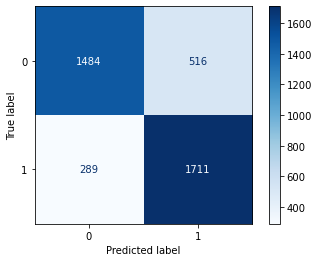

In [70]:
plot_confusion_matrix(rf_grid_binario, X_test_binario, y_test_binario, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

Comparando nuevamente los resultados de los modelos anteriormente aplicados en el conjunto de datos en **test** tenemos:

* Modelo benchmark - árbol de decisión: **71.12%**
* Support vector machine - kernel lineal: **82.6%**
* Random forest: **79.88%**

Se observa que para todos los modelos aplicados, el resultado de la métrica mejoró considerablemente, pero nuevamente se obtiene el algoritmo de **Support vector machine con kernel lineal** como el que permite tener el mejor modelo para nuestro problema. Comparándolo con el modelo obtenido para el problema multiclase, solo tuvo una variación en el hiperparámetro **C**.

### Simulemos nuestros modelos finales como si estuviesen en productivo con el conjunto dev

### Modelo Final Multiclase

In [71]:
data_dev = pd.read_json('data/dataset_es_dev.json', lines=True)

In [72]:
data_dev['review_normalize'] = data_dev.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))

In [73]:
X_dev = data_dev['review_normalize']
y_dev = data_dev['stars']

In [74]:
y_test_dev_svm = grid_svm.predict(X_dev)
accuracy_dev_svm = accuracy_score(y_dev, y_test_dev_svm)
print(f'Accuracy en Dev: {round(accuracy_dev_svm*100,2)}')

Accuracy en Dev: 44.44


### Modelo Final Binario

In [75]:
data_dev_binario = data_dev[data_dev.stars != 3]

In [76]:
data_dev_binario['Ind_Positivo'] = np.where(data_dev_binario.stars >= 4, 1, 0)

In [77]:
X_dev_binario = data_dev_binario['review_normalize']
y_dev_binario = data_dev_binario['Ind_Positivo']

In [78]:
y_dev_pred_svm_binario = grid_svm_binario.predict(X_dev_binario)
accuracy_dev_svm_binario = accuracy_score(y_dev_binario, y_dev_pred_svm_binario)
print(f'Accuracy en Dev: {round(accuracy_dev_svm_binario*100,2)}')

Accuracy en Dev: 82.62


Se puede observar que para ambos modelos el comportamiento en productivo es el esperado, es decir, que nuestro modelo logró generalizar bien.

## Conclusiones

* Como primera conclusión, se puede resaltar el óptimo desempeño del algoritmo **Support vector machine con kernel lineal** para este tipo de problema, en el procesamiento de lenguaje natural.

* La librería Spacy facilita muchas actividades a la hora de enfrentarnos a un problema de procesamiento de lenguaje natural, sobretodo para el idioma español. Pero utilizar algunas funciones de dicha librería en ocasiones es más costoso computacionalmente que utilizar librerías creadas mediante expresiones regulares. Importante resaltar el poder de Spacy para tokenizar y a la hora de lematizar, aunque como se pudo apreciar en varias palabras, la lematización tiene su pequeño margen de error.

* Para la solución del problema se aplicó una de las técnica de vectorización, sería interesante aplicar la vectorización **TF-IDF** para conocer si se tiene una mejoría considerable en los modelos.

* Un tema para investigar y profundizar, sería aplicar funciones para corregir ortografía. Puede ser interesante saber que tanto puede mejorar un modelo, teniendo textos con mejor ortografía, dado que esas palabras mal escritas se pierden a la hora de la vectorización.